Raw shape: (582, 18)
After dropna: (582, 18)

Class distribution (after merge):
pop_binary
Medium    444
High      135
Name: count, dtype: int64

Features shape (numeric): (579, 11)


/tmp/ipython-input-3304180734.py:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['pop_binary'] = df['pop_level_3'].replace({'Low': 'Medium'})  # об’єднання Low → Medium



Cross-validation accuracy (5-fold):
  RandomForest (no PCA):    0.7168 ± 0.0838

RandomForest (no PCA)
  Test accuracy: 0.7414
  Fit time: 0.6214s | Predict time: 0.066279s
  Confusion matrix:
 [[81  8]
 [22  5]]
  Classification report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.84        89
           1       0.38      0.19      0.25        27

    accuracy                           0.74       116
   macro avg       0.59      0.55      0.55       116
weighted avg       0.69      0.74      0.71       116


  PCA(0.95)+RandomForest:  0.7324 ± 0.0848

PCA(0.95)+RandomForest
  PCA components kept: 9 (of 11)
  Explained variance sum: 0.966
  Test accuracy: 0.7586
  Fit time: 0.6289s | Predict time: 0.067747s
  Confusion matrix:
 [[81  8]
 [20  7]]
  Classification report:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85        89
           1       0.47      0.26      0.33        27



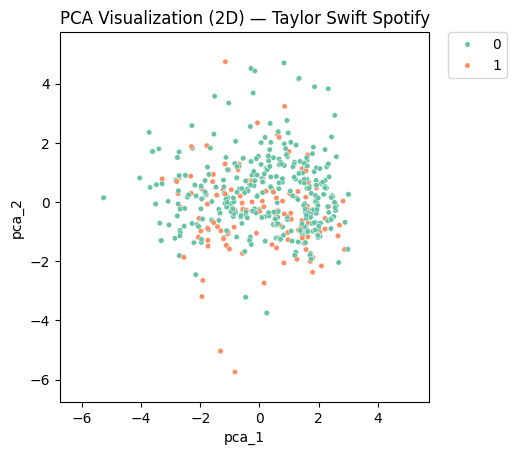

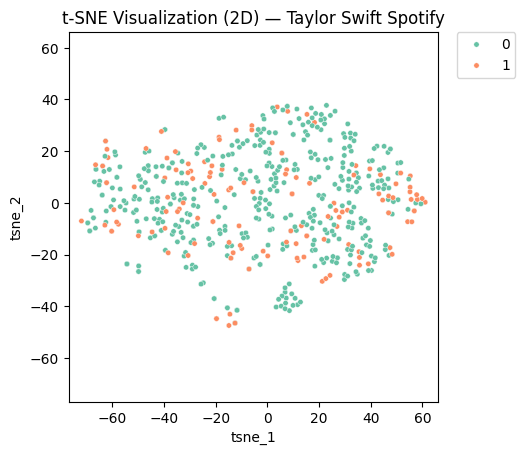

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- 1. Завантаження даних ---
df = pd.read_csv("taylor_swift_spotify.csv")
print("Raw shape:", df.shape)
df = df.dropna()
print("After dropna:", df.shape)

# --- 2. Вибір потрібних стовпців ---
cols = [
    'track_number', 'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'duration_ms'
]
df = df[cols]

# --- 3. Створення двох класів ---
df['pop_level_3'] = pd.cut(df['popularity'], bins=[0, 50, 70, 100], labels=['Low', 'Medium', 'High'])
df['pop_binary'] = df['pop_level_3'].replace({'Low': 'Medium'})  # об’єднання Low → Medium

# видалення рідкісних або NaN значень
df = df[df['pop_binary'].notna()]
print("\nClass distribution (after merge):")
print(df['pop_binary'].value_counts())

# --- 4. Підготовка ---
X = df.drop(['popularity', 'pop_level_3', 'pop_binary'], axis=1)
y = df['pop_binary'].map({'Medium': 0, 'High': 1})  # 0=Medium, 1=High

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFeatures shape (numeric):", X.shape)

# --- 5. RandomForest без PCA ---
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

cv_acc = cross_val_score(rf, X_scaled, y, cv=5)
print("\nCross-validation accuracy (5-fold):")
print(f"  RandomForest (no PCA):    {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

start_fit = time.time()
rf.fit(X_train, y_train)
fit_time = time.time() - start_fit

start_pred = time.time()
y_pred = rf.predict(X_test)
pred_time = time.time() - start_pred

print(f"\nRandomForest (no PCA)")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"  Fit time: {fit_time:.4f}s | Predict time: {pred_time:.6f}s")
print("  Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("  Classification report:\n", classification_report(y_test, y_pred))

# --- 6. RandomForest + PCA ---
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

rf_pca = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

cv_acc_pca = cross_val_score(rf_pca, X_pca, y, cv=5)
print(f"\n  PCA(0.95)+RandomForest:  {cv_acc_pca.mean():.4f} ± {cv_acc_pca.std():.4f}")

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

start_fit_p = time.time()
rf_pca.fit(X_train_p, y_train_p)
fit_time_p = time.time() - start_fit_p

start_pred_p = time.time()
y_pred_p = rf_pca.predict(X_test_p)
pred_time_p = time.time() - start_pred_p

print(f"\nPCA(0.95)+RandomForest")
print(f"  PCA components kept: {pca.n_components_} (of {X.shape[1]})")
print(f"  Explained variance sum: {pca.explained_variance_ratio_.sum():.3f}")
print(f"  Test accuracy: {accuracy_score(y_test_p, y_pred_p):.4f}")
print(f"  Fit time: {fit_time_p:.4f}s | Predict time: {pred_time_p:.6f}s")
print("  Confusion matrix:\n", confusion_matrix(y_test_p, y_pred_p))
print("  Classification report:\n", classification_report(y_test_p, y_pred_p))

# --- 7. PCA для візуалізації ---
pca_2d = PCA(n_components=2)
pca_result = pca_2d.fit_transform(X_scaled)
pca_df = pd.DataFrame({'pca_1': pca_result[:,0], 'pca_2': pca_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_df, ax=ax, s=15, palette='Set2')
lim = (pca_result.min()-1, pca_result.max()+1)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("PCA Visualization (2D) — Taylor Swift Spotify")
plt.show()

# --- 8. t-SNE ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
tsne_result = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_df, ax=ax, s=15, palette='Set2')
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("t-SNE Visualization (2D) — Taylor Swift Spotify")
plt.show()




Image shape: (1280, 960, 3)
dtype: uint8


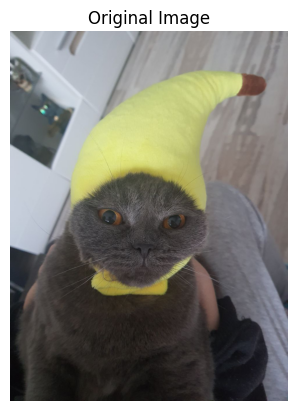

Унікальних кольорів у вихідному зображенні: 52276


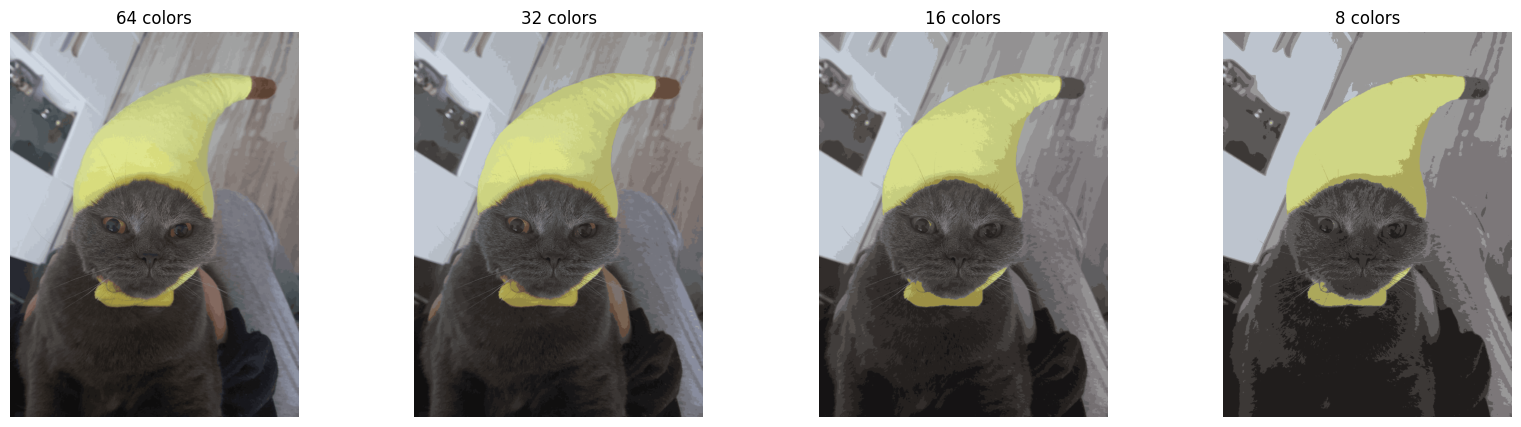

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import imageio.v2 as imageio

# Завантажуємо зображення
img = imageio.imread("photo_2025-10-22_22-50-08.jpg")
H, W, C = img.shape
print("Image shape:", img.shape)
print("dtype:", img.dtype)

plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Нормалізація зображення до [0,1]
data = img / 255.0
pixels = data.reshape(-1, 3)

# Функція для квантування зображення за допомогою k-means
def quantize_image(pixels, H, W, n_colors):
    kmeans = KMeans(n_clusters=n_colors, random_state=0, n_init=10)
    kmeans.fit(pixels)
    new_colors = kmeans.cluster_centers_[kmeans.labels_]
    quantized_img = new_colors.reshape(H, W, 3)
    return quantized_img

# Кількість унікальних кольорів у вихідному зображенні
unique_colors_original = np.unique(img.reshape(-1, 3), axis=0)
print("Унікальних кольорів у вихідному зображенні:", unique_colors_original.shape[0])

# Список кількостей кольорів для квантування
color_levels = [64, 32, 16, 8]

# Порівняння
fig, axes = plt.subplots(1, len(color_levels), figsize=(20, 5))

for ax, n_colors in zip(axes, color_levels):
    q_img = quantize_image(pixels, H, W, n_colors)
    ax.imshow(q_img)
    ax.set_title(f"{n_colors} colors")
    ax.axis('off')





Кількість рядків у вибраних альбомах:
album
1989    953
Red     845
Name: count, dtype: int64


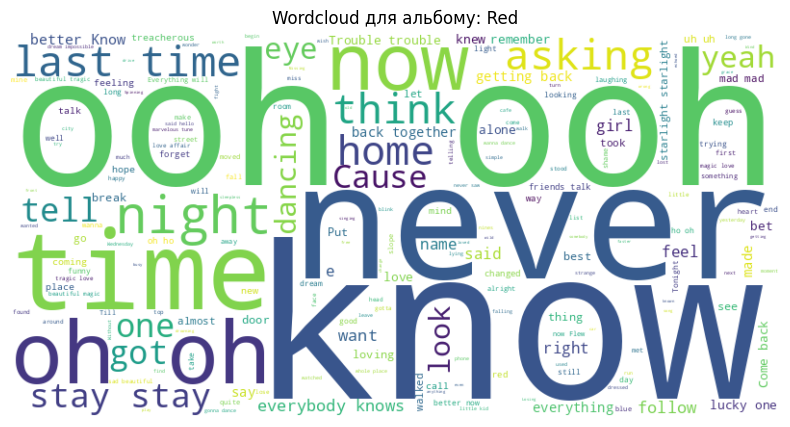

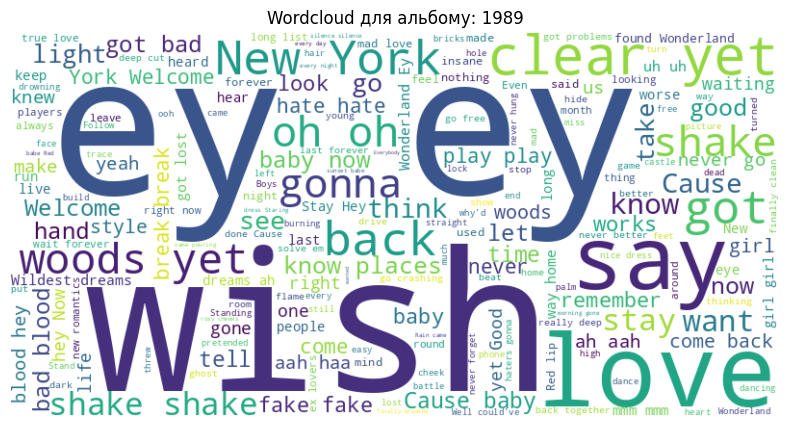


Розмір навчальної вибірки: (1438, 1000)
Розмір тестової вибірки: (360, 1000)

=== Класифікаційний звіт ===
              precision    recall  f1-score   support

        1989       0.84      0.81      0.83       191
         Red       0.80      0.83      0.81       169

    accuracy                           0.82       360
   macro avg       0.82      0.82      0.82       360
weighted avg       0.82      0.82      0.82       360



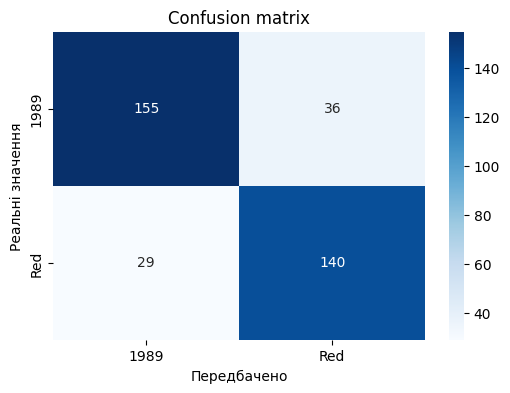

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# === Завантаження даних ===
df = pd.read_csv("/content/taylor_swift_lyrics.csv", encoding='latin1')

# === Попередня обробка ===
df = df.dropna(subset=["lyric", "album"])
df["lyric"] = df["lyric"].astype(str)

# === Вибір 2 альбомів для класифікації ===
albums_to_use = ['Red', '1989']
df = df[df['album'].isin(albums_to_use)]

print("\nКількість рядків у вибраних альбомах:")
print(df['album'].value_counts())

# === WordCloud для кожного альбому ===
def visualize(album_name):
    album_data = df[df["album"] == album_name]
    album_text = " ".join(album_data["lyric"].dropna().astype(str))

    if len(album_text.strip()) == 0:
        print(f"Пропуск альбому '{album_name}' — немає текстів пісень.")
        return

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(album_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud для альбому: {album_name}")
    plt.show()

for alb in albums_to_use:
    visualize(alb)

# === Підготовка даних для моделі ===
X = df["lyric"]
y = df["album"]

# TF-IDF з n-grams (1-2) і менше ознак для стабільності
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, ngram_range=(1,2))
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)

print("\nРозмір навчальної вибірки:", X_train.shape)
print("Розмір тестової вибірки:", X_test.shape)

# === Навчання MultinomialNB ===
model = MultinomialNB(alpha=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# === Оцінка якості ===
print("\n=== Класифікаційний звіт ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Передбачено")
plt.ylabel("Реальні значення")
plt.title("Confusion matrix")
plt.show()



